This notebook is used to postprocess and compare the LE simulations of different modeling configurations

In [1]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [2]:
import pickle
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import pandas as pd
from jax_canoak.subjects import get_met_forcings, get_obs, initialize_parameters
from jax_canoak.shared_utilities import compute_metrics

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_imshow2,
    plot_timeseries_obs_1to1,
)


# Files and folders

In [3]:
site = "US-Wkg"

# Calibration period
f_forcing = f"../../data/fluxtower/{site}/{site}-forcings.csv"
f_obs = f"../../data/fluxtower/{site}/{site}-fluxes.csv"

# Test period
f_forcing_test = f"../../data/fluxtower/{site}/{site}-forcings-test.csv"
f_obs_test = f"../../data/fluxtower/{site}/{site}-fluxes-test.csv"

# Model parameters

In [4]:
time_zone = -8
latitude = 46.4089
longitude = -119.2750
stomata = 0
veg_ht = 1.2
leafangle = 2  # erectophile
n_can_layers = 50
n_atmos_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 15


# Load data

## Load forcings and observations

In [5]:
# Train
obs = get_obs(f_obs)
met, n_time = get_met_forcings(f_forcing)

# Test
obs_test = get_obs(f_obs_test)
met_test, n_time = get_met_forcings(f_forcing_test)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)
2023-12-01 15:21:59.279823: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 42297524224
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.inf

## Load the setup

In [6]:
setup, para, para_min, para_max = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=1,
    npart=int(1e6),
    obs=obs,
    met=met,
    niter=niter,
    get_para_bounds=True,
)

## Load simulations

In [7]:
# No DL
key1 = "nodl"
f_out1 = f"{site}_{key1}.pkl"
out1 = pickle.load(open(f_out1, "rb"))

In [8]:
# Pure DL
key2 = "dl"
f_out2 = f"{site}_{key2}.pkl"
out2 = pickle.load(open(f_out2, "rb"))

In [9]:
# Hybrid
key3 = "hybridRH"
f_out3 = f"{site}_{key3}.pkl"
out3 = pickle.load(open(f_out3, "rb"))

In [10]:
timesteps = out1['train']['time']
timesteps_test = out1['test']['time']

## Combine 

In [11]:
le_train = pd.DataFrame(
    data={
        "obs": obs.LE,
        key1: out1["train"]["can.LE"],
        key2: out2["train"]["LE"],
        key3: out3["train"]["can.LE"],
    },
    index=out1["train"]["time"],
)
le_test = pd.DataFrame(
    data={
        "obs": obs_test.LE,
        key1: out1["test"]["can.LE"],
        key2: out2["test"]["LE"],
        key3: out3["test"]["can.LE"],
    },
    index=out1["test"]["time"],
)

# Compute the performances

In [12]:
metrics_keys = ["rmse", "mse", "r2", "kge", "mkge", "cc", "nse"]
metrics_df = pd.DataFrame(columns=metrics_keys, index=[key1, key2, key3])
metrics_test_df = pd.DataFrame(columns=metrics_keys, index=[key1, key2, key3])
for key in [key1, key2, key3]:
    metrics = compute_metrics(le_train["obs"], le_train[key])
    metrics_test = compute_metrics(le_test["obs"], le_test[key])
    for m in metrics_keys:
        metrics_df.loc[key, m] = metrics[m]
    for m in metrics_keys:
        metrics_test_df.loc[key, m] = metrics_test[m]

In [13]:
metrics_df

,rmse,mse,r2,kge,mkge,cc,nse
nodl,28.052511,786.943377,0.596619,0.654203,0.599648,0.773495,0.363751
dl,20.909544,437.209013,0.77589,0.843302,0.822057,0.881482,0.729448
hybridRH,25.855001,668.481077,0.657342,0.760828,0.757345,0.812819,0.547774


In [14]:
metrics_test_df

,rmse,mse,r2,kge,mkge,cc,nse
nodl,27.732272,769.07891,0.561444,0.586493,0.398191,0.755038,0.262673
dl,22.017622,484.775675,0.723564,0.575572,0.692088,0.864038,0.467493
hybridRH,28.177387,793.96513,0.547253,0.302209,0.442949,0.756027,-0.225674


# Plot

## LE

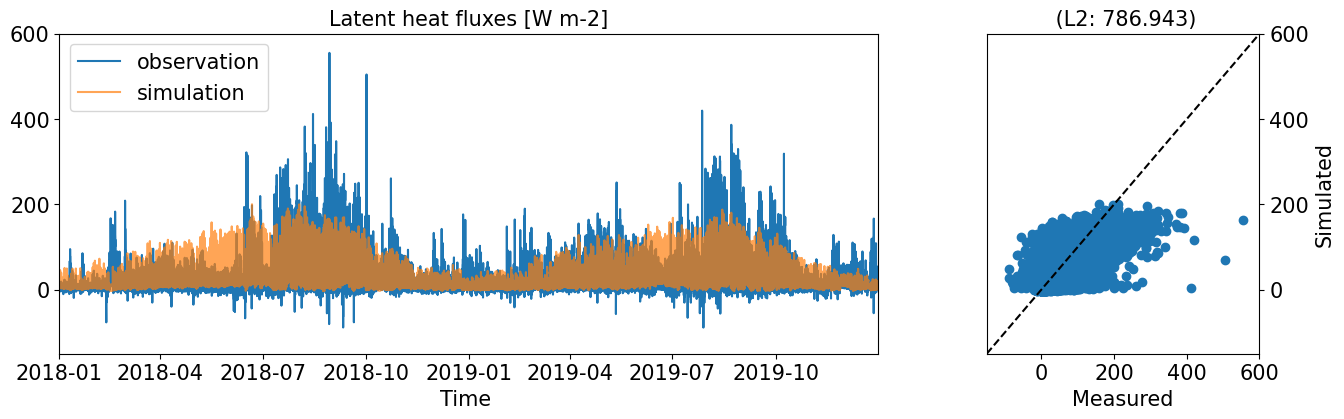

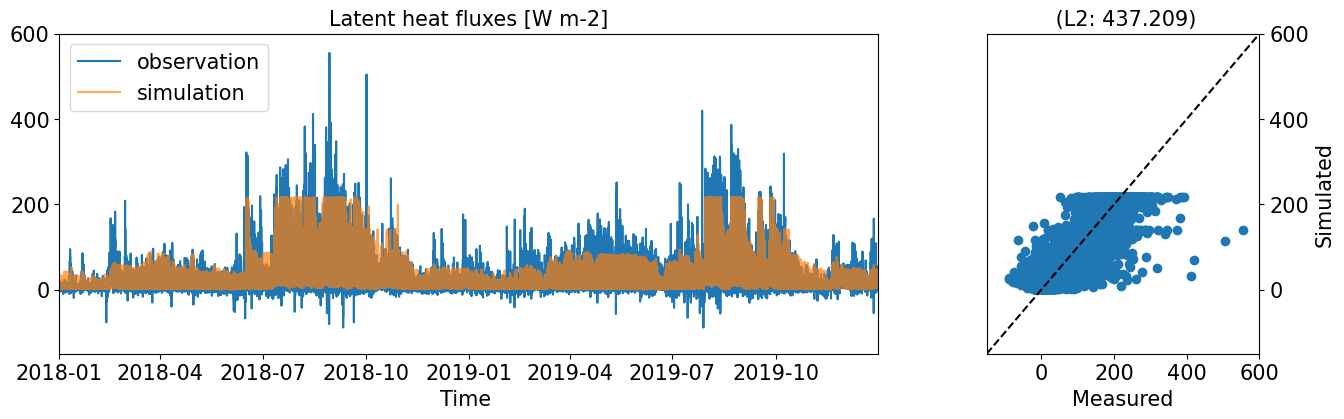

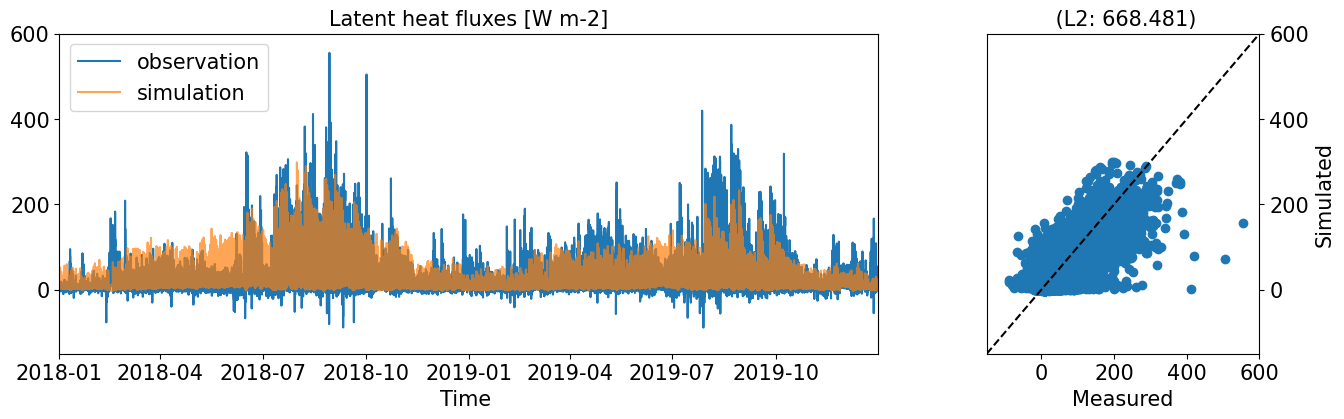

In [15]:
for out in [out1, out2, out3]:
    try:
        can_LE = out['train']['can.LE']
    except:
        can_LE = out['train']['LE']
    fig, ax1, ax2 = plot_timeseries_obs_1to1(
        obs.LE,
        can_LE,
        lim=[-150, 600],
        met=met,
        varn="Latent heat fluxes [W m-2]",
        # linestyle=".",
    )


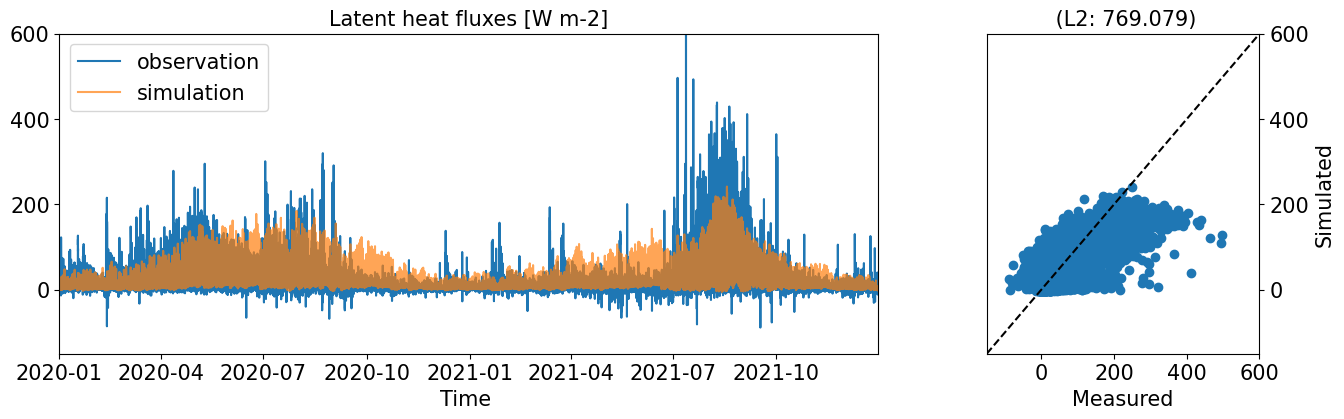

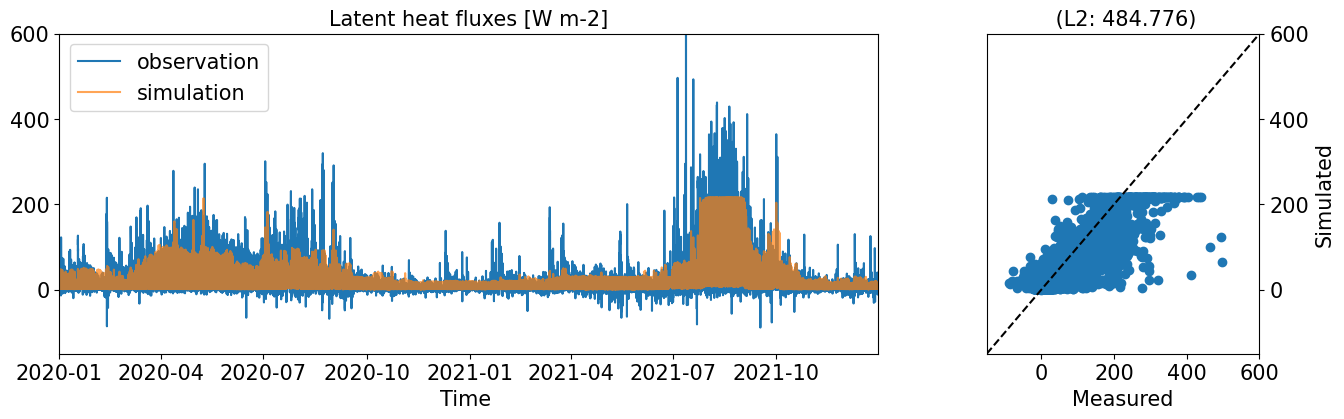

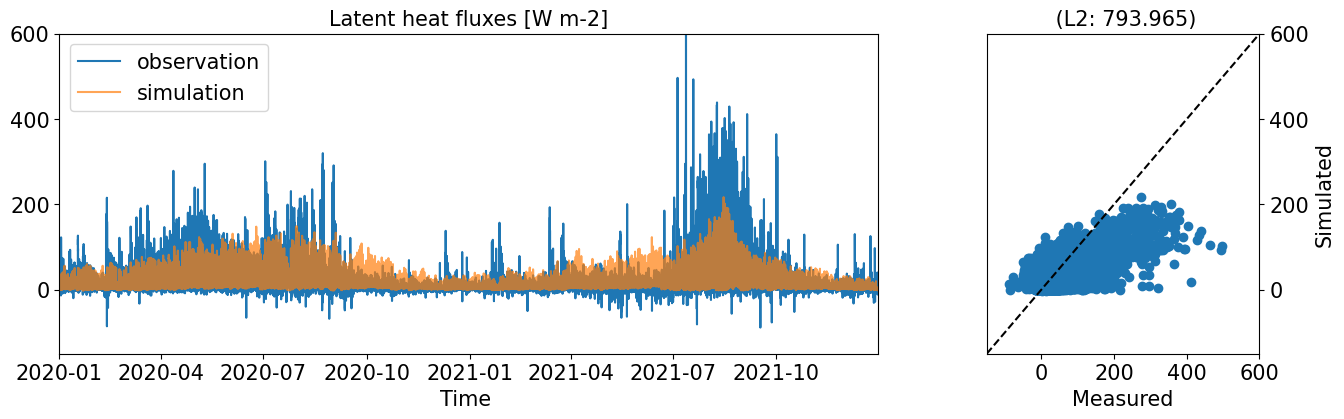

In [16]:
for out in [out1, out2, out3]:
    try:
        can_LE = out['test']['can.LE']
    except:
        can_LE = out['test']['LE']
    fig, ax1, ax2 = plot_timeseries_obs_1to1(
        obs_test.LE,
        can_LE,
        lim=[-150, 600],
        met=met_test,
        varn="Latent heat fluxes [W m-2]",
        # linestyle=".",
    )


## Stomatal conductance

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


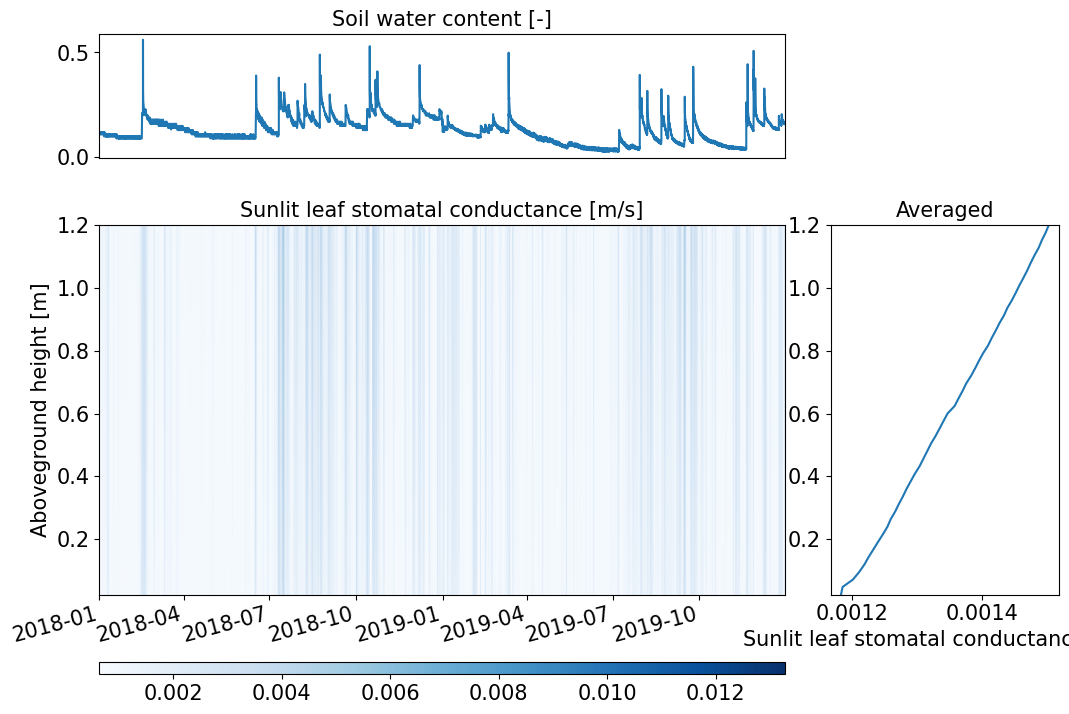

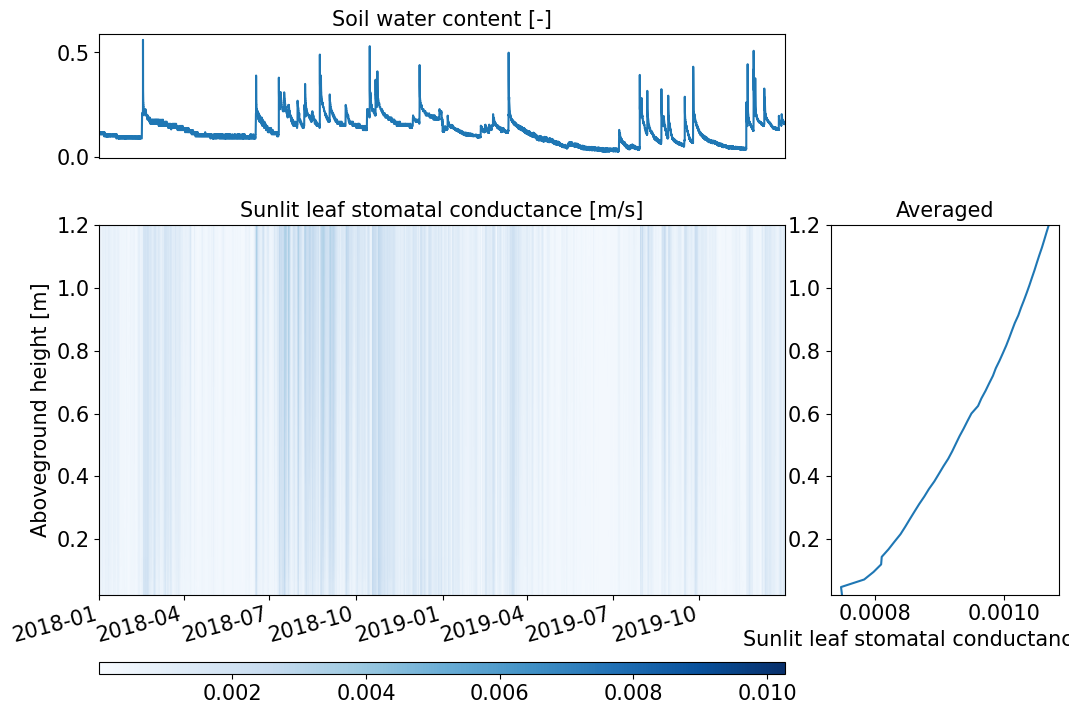

In [17]:
for out in [out1, out3]:
    can = out['train']['sun.gs'].T
    plot_imshow2(
        can,
        met,
        para.zht1,
        key="swc",
        title="Sunlit leaf stomatal conductance [m/s]",
        cmap="Blues",
    )


/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


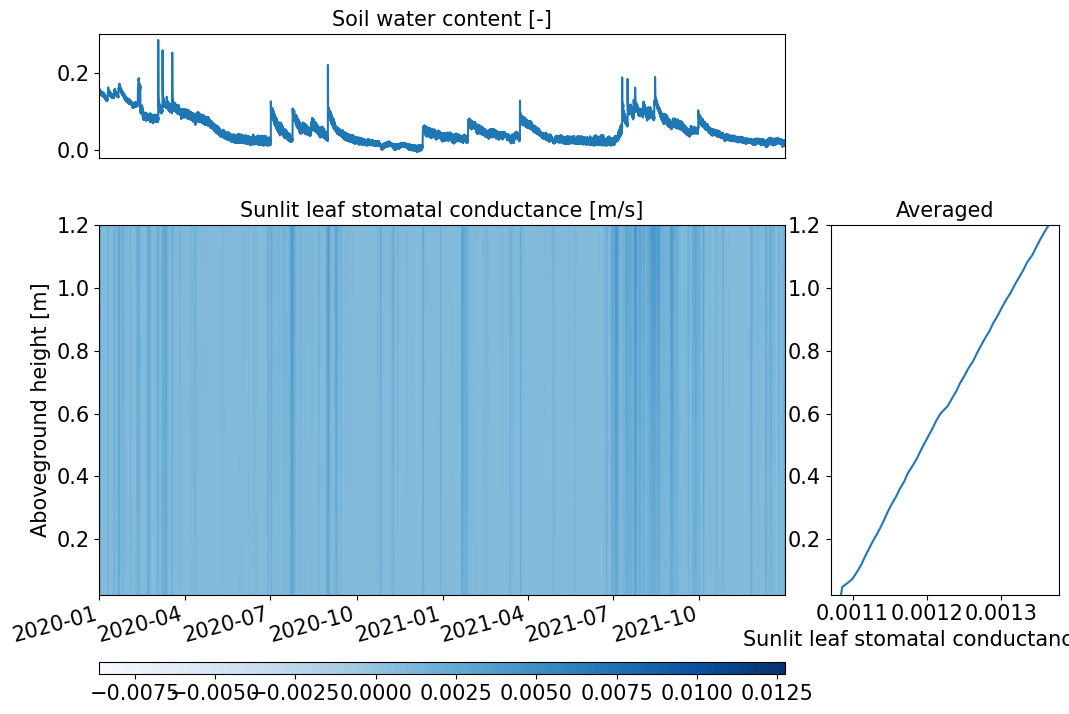

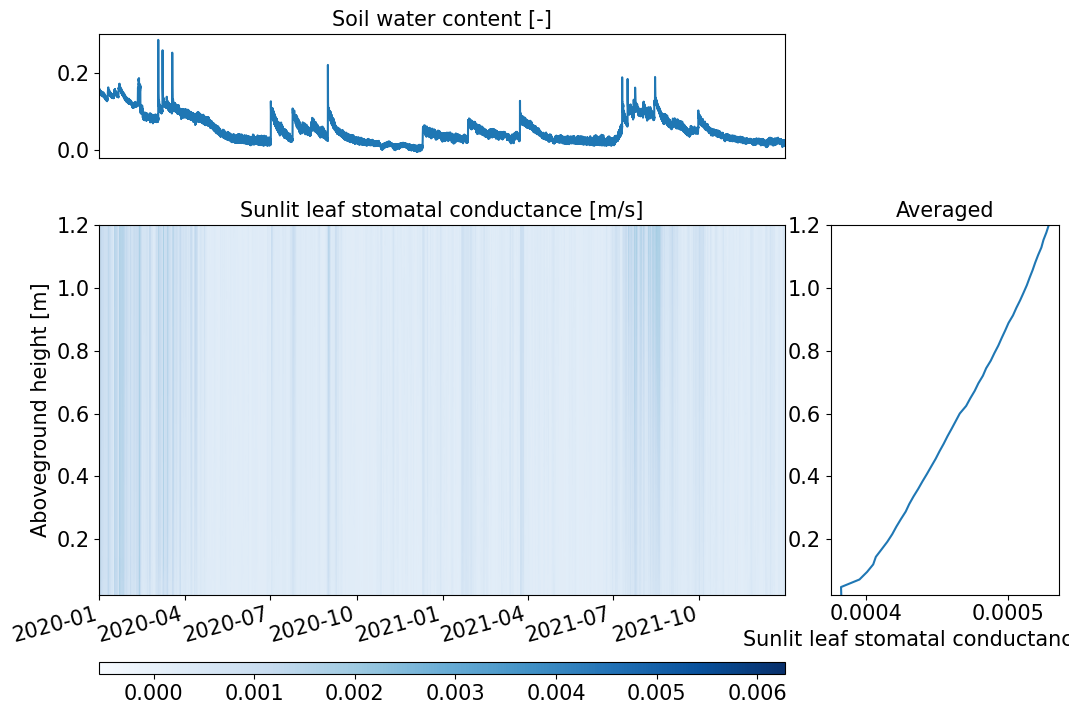

In [18]:
for out in [out1, out3]:
    can = out['test']['sun.gs'].T
    plot_imshow2(
        can,
        met_test,
        para.zht1,
        key="swc",
        title="Sunlit leaf stomatal conductance [m/s]",
        cmap="Blues",
    )


## Leaf relative humidity

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


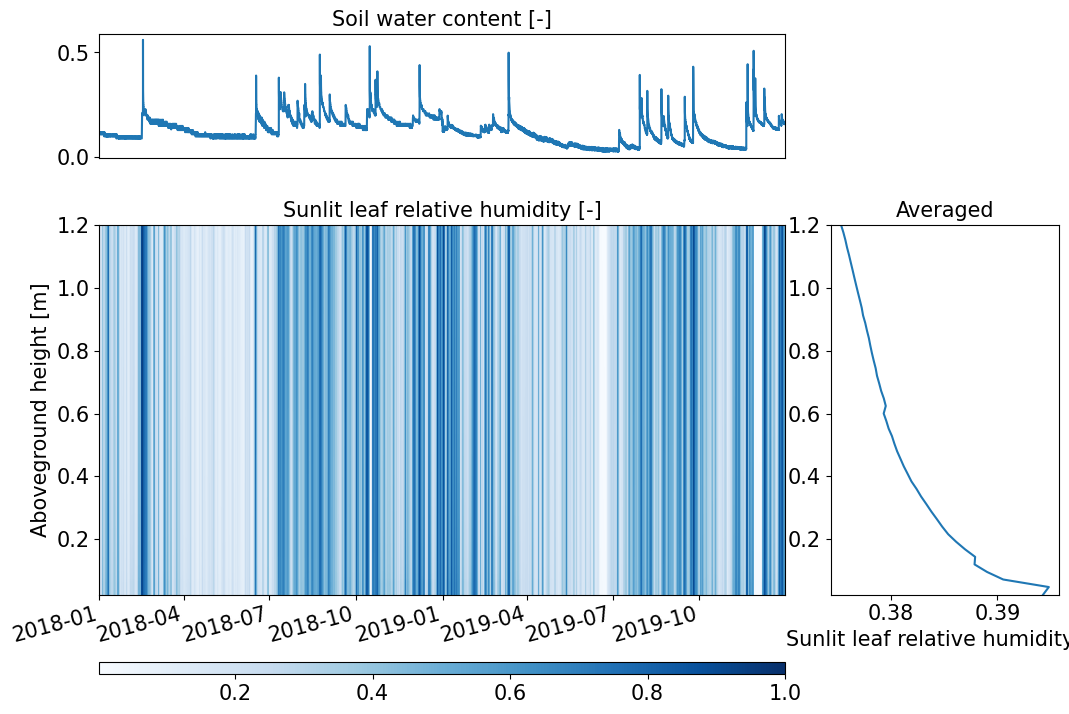

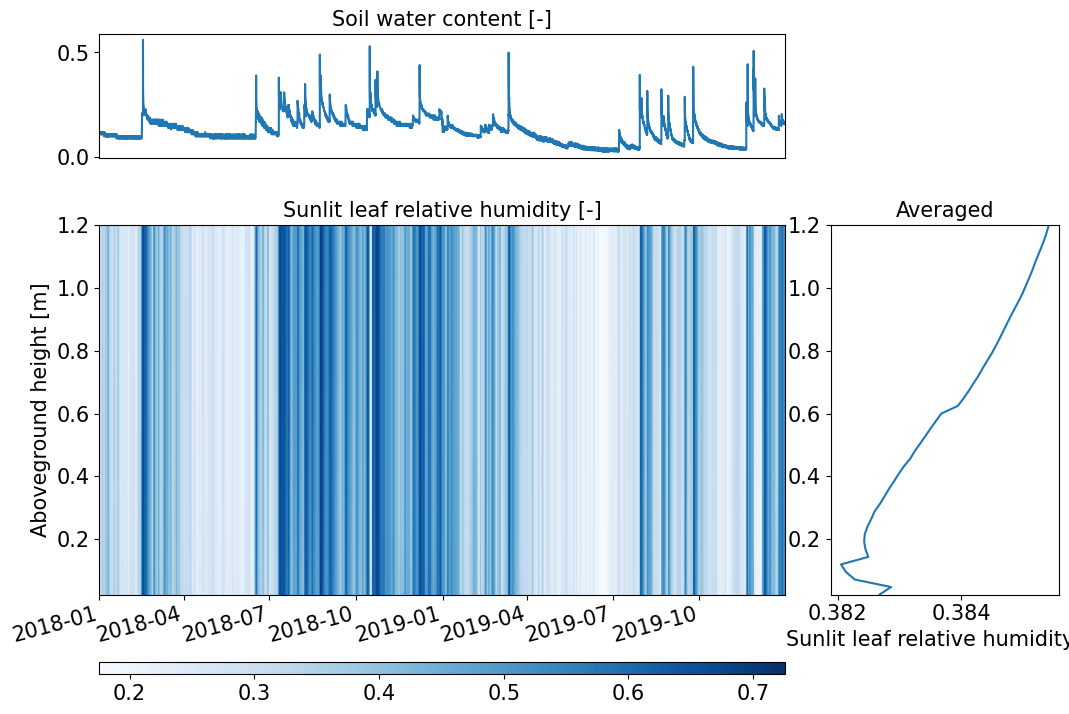

In [19]:
for out in [out1, out3]:
    can = out['train']['sun.Leaf_RH'].T
    plot_imshow2(
        can,
        met,
        para.zht1,
        key="swc",
        title="Sunlit leaf relative humidity [-]",
        cmap="Blues",
    )


/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:115: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


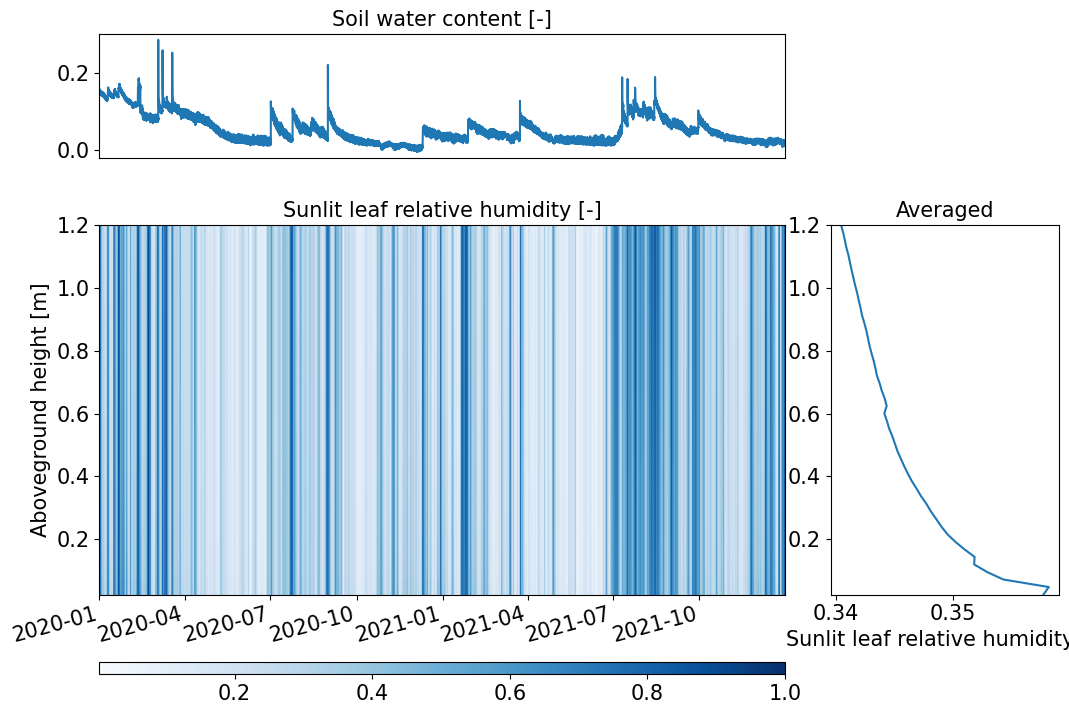

In [ ]:
for out in [out1, out3]:
    can = out['test']['sun.Leaf_RH'].T
    plot_imshow2(
        can,
        met_test,
        para.zht1,
        key="swc",
        title="Sunlit leaf relative humidity [-]",
        cmap="Blues",
    )
